In [1]:
import io
import os
import unicodedata
import string
import glob

import torch
import random

https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
### alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)
print("all letters => ", ALL_LETTERS)
print("total number of letters => ", N_LETTERS)

all letters =>  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
total number of letters =>  57


In [4]:
### Turn a Unicode string to plain ASCII  ...  this function will return only ascii characters ... it will remove all special characters
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

# print("Original letters => ", "üåêîõ")
# print("After cleaning => ", unicode_to_ascii("üåêîõ"))

In [5]:
def load_data():
    ## Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        ### The glob module, which is short for global, is a function that's used to search for files that match a specific file pattern or name.
        return glob.glob(path)
    
    ## Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    ## iterate through all file present in the directory
    for filename in find_files('data/names/*.txt'):
        ## take only name of the file name without file extention
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        ## dictionary store all lines of the file
        category_lines[category] = lines
    return category_lines, all_categories

In [6]:
print(ALL_LETTERS.find('m'))

12


In [7]:
### example of below function

test_tensor1 = torch.zeros(1, 10).to(device)
print(test_tensor1)
print()
print(test_tensor1.shape)
test_tensor1[0][6] = 1
print()
print(test_tensor1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

torch.Size([1, 10])

tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], device='cuda:0')


In [8]:
"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

### Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)     ## find out the index position of the letter

### Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS).to(device)              ## 1 x 57  ..  because (57) is the total number of letters
    tensor[0][letter_to_index(letter)] = 1          ## change the index position of the letter from zero (0) to one (1)
    return tensor                                   ## return the modifield tensor

## Turn a line into a <line_length x 1 x n_letters>,
## or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS).to(device)       ## if length of line or there are 45 words then tensor size will be ( 45, 1, 57 )
    for i, letter in enumerate(line):                   ## iterate through all words
        tensor[i][0][letter_to_index(letter)] = 1       ## change the index position of the letter from zero (0) to one (1)
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)            ## random value between (0 to all_categories)
    line = random_choice(category_lines[category])          ## random value between 
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long).to(device)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
torch.Size([5, 1, 57])


In [9]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt

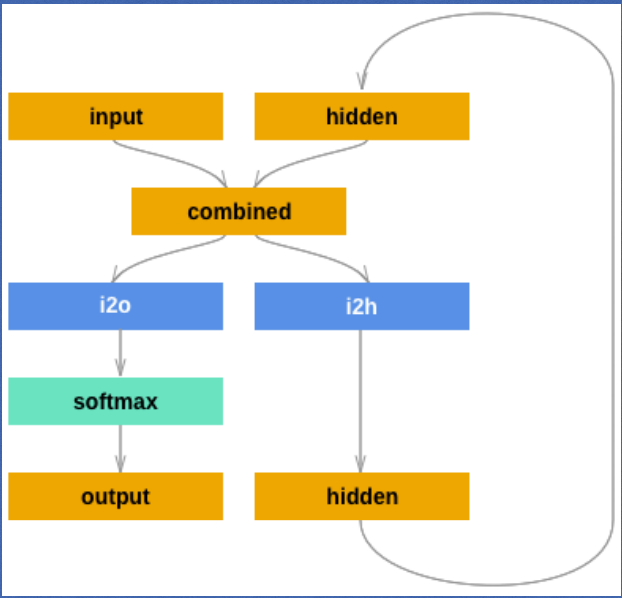

In [10]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.input_to_hidden = nn.Linear(in_features= input_size + hidden_size, out_features= hidden_size)
        self.input_to_output = nn.Linear(in_features= input_size + hidden_size, out_features= output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), dim = 1)
        hidden = self.input_to_hidden(combined)
        output = self.input_to_output(combined)
        output = self.softmax(output)

        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size).to(device)

In [11]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

In [12]:
## print(category_lines)     ## it it a dictionary contain category name as key and other words as value of that key .. (all words are in list)
print(all_categories)
print(n_categories)

['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
18


In [13]:
n_hidden = 128
rnn = RNN(input_size= N_LETTERS, hidden_size= n_hidden, output_size= n_categories).to(device)

In [14]:
### one step
input_tensor = letter_to_tensor('A')
print("input tensor")
print(input_tensor)

hidden_tensor = rnn.init_hidden()

print("hidden tensor")
print(hidden_tensor)

output, next_hidden = rnn(input_tensor, hidden_tensor)
print()

print(output.size())
print(next_hidden.size())

print()
print("output")
print(output)               ## randomly generated values
print("next hidden")
print(next_hidden)          ## randomly generated values

input tensor
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]], device='cuda:0')
hidden tensor
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

torch.Size([1, 18])
torch.Size([1, 128])

output
tensor([[-3.0144, -2.8990, -2.9772, -2.7521, -2.8897, -

In [15]:
# ### whole sequence/name

# input_tensor = line_to_tensor('Albert')
# print("input tensor")
# print(input_tensor)

# hidden_tensor = rnn.init_hidden()

# print("hidden tensor")
# print(hidden_tensor)

# output, next_hidden = rnn(input_tensor[0], hidden_tensor)
# print()

# print(output.size())
# print(next_hidden.size())

# print()
# print("output")
# print(output)               ## randomly generated values
# print("next hidden")
# print(next_hidden)          ## randomly generated values

In [16]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()      ## findout the maximum value of the tensor and it will return index
    return all_categories[category_idx]

# print(category_from_output(output))

In [17]:
"""
The Negative Log-Likelihood Loss function (NLL) is applied only on models with the softmax function as an output activation layer. 
Softmax refers to an activation function that calculates the normalized exponential function of every unit in the layer.
"""
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [18]:
def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()          ## it is zeros of dimension => ( 1, hidden_size)
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [19]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

5000 5.0 2.8027 Roffey / Russian WRONG (English)
10000 10.0 1.0478 Asahara / Japanese CORRECT
15000 15.0 1.7125 Ton / Korean WRONG (Vietnamese)
20000 20.0 1.7387 Movsumadze / Russian CORRECT
25000 25.0 1.8037 Menendez / Dutch WRONG (Spanish)
30000 30.0 0.6930 Sam / Chinese CORRECT
35000 35.0 0.9910 Bieber / German CORRECT
40000 40.0 0.8704 Leeuwenhoeck / Dutch CORRECT
45000 45.0 2.7579 Seif / Korean WRONG (Arabic)
50000 50.0 4.7751 Maas / Chinese WRONG (Dutch)
55000 55.00000000000001 0.2983 AbdankKossovsky / Russian CORRECT
60000 60.0 1.6931 Kerby / English CORRECT
65000 65.0 0.0792 Akrivopoulos / Greek CORRECT
70000 70.0 0.3426 Pezos / Greek CORRECT
75000 75.0 0.9088 Davidson / Scottish CORRECT
80000 80.0 0.3664 Thi / Vietnamese CORRECT
85000 85.0 2.6199 Santana / Spanish WRONG (Portuguese)
90000 90.0 2.0238 Feltham / Irish WRONG (English)
95000 95.0 0.4580 Avrov / Russian CORRECT
100000 100.0 0.3626 Kuijpers / Dutch CORRECT


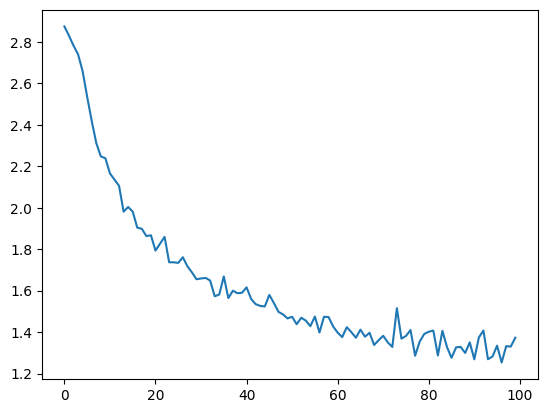

In [20]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [23]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)

predict("Agar")

# while True:
#     sentence = input("Input:")
#     if sentence == "quit":
#         break
    
#     predict(sentence)


> Agar
German
